Route 1: [0, 20, 21, 22, 23, 26, 28, 27, 25, 24, 29, 30, 34, 36, 0]
Truck capacity: 200.0
Total distance travelled: 92.97583841114069

Route 2: [0, 67, 65, 63, 62, 66, 69, 68, 64, 61, 72, 74, 0]
Truck capacity: 200.0
Total distance travelled: 63.05598885701291

Route 3: [0, 5, 3, 4, 6, 8, 9, 11, 10, 7, 75, 1, 2, 98, 0]
Truck capacity: 200.0
Total distance travelled: 90.60041095786515

Route 4: [0, 43, 42, 41, 40, 44, 45, 46, 48, 50, 51, 52, 49, 47, 31, 35, 59, 0]
Truck capacity: 200.0
Total distance travelled: 147.0905266333047

Route 5: [0, 90, 89, 88, 85, 84, 83, 82, 86, 87, 91, 96, 99, 94, 0]
Truck capacity: 200.0
Total distance travelled: 132.99756218770892

Route 6: [0, 13, 17, 18, 19, 15, 16, 14, 12, 55, 0]
Truck capacity: 200.0
Total distance travelled: 164.89765374122294

Route 7: [0, 32, 33, 37, 38, 39, 57, 53, 0]
Truck capacity: 200.0
Total distance travelled: 152.57053420825886

Route 8: [0, 95, 97, 93, 92, 100, 81, 78, 76, 0]
Truck capacity: 200.0
Total distance travelled: 

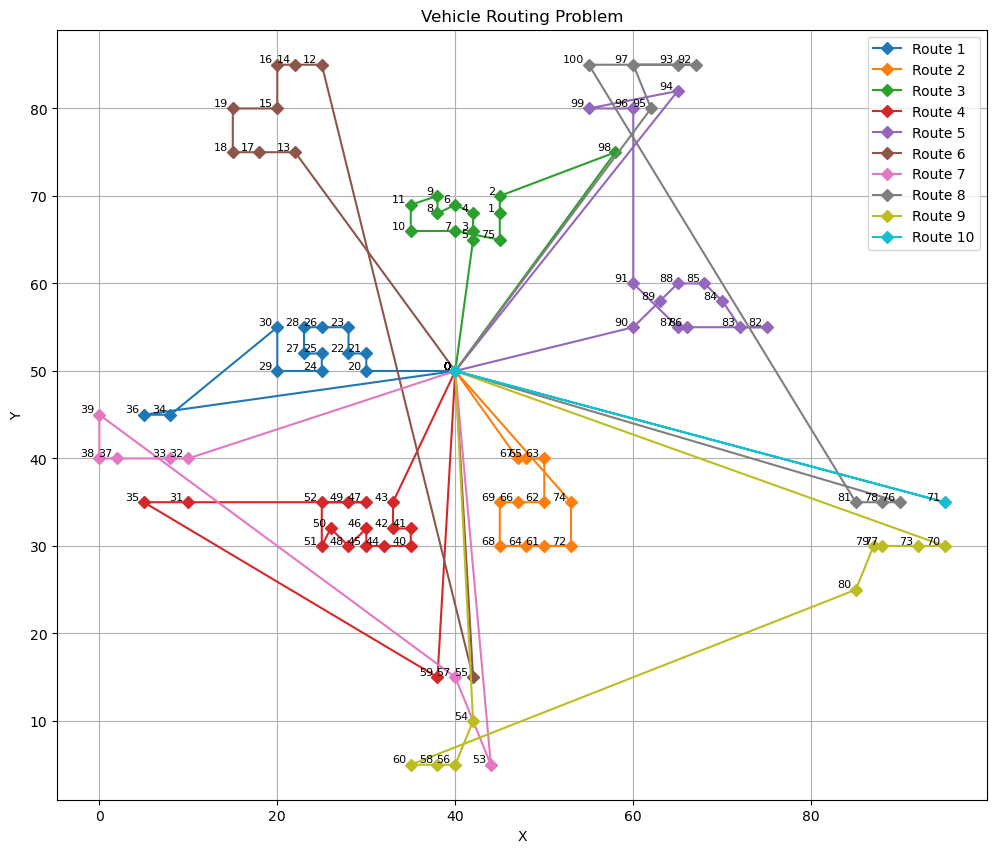

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_excel_file(filename, sheet_name):
    """
    Read coordinates and demand values from a specific sheet in an Excel file.
    Assumes the data is in columns labeled 'X', 'Y', and 'Demand'.
    """
    df = pd.read_excel(filename, sheet_name=sheet_name)
    coordinates = df[['X', 'Y']].values
    demands = df['Demand'].values
    return coordinates, demands

def read_txt_file(file_path):
    """
    Reads a VRP text file and extracts vehicle and customer information.
    """
    with open(file_path, 'r') as file:      # Read data
        lines = file.readlines()            # Split data into line
    vehicle_info = lines[4].split()         # Informations about vehicles are on line 5 for Solomon instance (index 4)
    vehicle_number = vehicle_info[0]        # Number of vehicle available
    vehicle_capacity = vehicle_info[1]      # Maximun capacity allowed in vehicle
    customer_data_start = lines.index("CUSTOMER\n") + 3  # Informations about customers start 3 lines after the index of the word "CUSTOMER"
    customer_lines = lines[customer_data_start:]
    
    coordinates = []
    demands = []
    ready_times = []
    due_times = []
    service_times = []
    
    for line in customer_lines:
        if line.strip():  # Skip empty lines
            values = list(map(float, line.split()))
            coordinates.append((values[1], values[2]))  # (X, Y)
            demands.append(values[3])  # Demand
            ready_times.append(values[4])  # Ready Time
            due_times.append(values[5])  # Due Date
            service_times.append(values[6])  # Service Time
    
    return vehicle_number, vehicle_capacity, coordinates, demands, ready_times, due_times, service_times
   
def adjacency_matrix(coordinates):
    """
    Calculate the adjacency matrix.
    """
    num_points = len(coordinates)
    adj_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            adj_matrix[i, j] = calculate_distance(coordinates, i, j)
    return adj_matrix

def calculate_distance(coordinates, i, j):
    """
    Calculate the Euclidean distance between two points.
    """
    x1, y1 = coordinates[i]
    x2, y2 = coordinates[j]
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def calculate_total_distance(route, adj_matrix):
    """
    Calculate the total distance of a given route using the distance matrix.
    """
    total_distance = 0
    num_points = len(route)
    for i in range(num_points - 1):
        current_node = route[i]
        next_node = route[i + 1]
        total_distance += adj_matrix[current_node, next_node]
    return total_distance

def nearest_neighbor(adj_matrix, demands, capacity_max):
    """
    Apply the Nearest Neighbor heuristic to find initial routes for VRP.
    """
    num_points = adj_matrix.shape[0]
    visited = [False] * num_points   # List of boolean to know if a node is visited or not
    routes = []
    capacity_list = []
    while sum(visited) < num_points:
        current_node = 0  # Start at node 0
        current_capacity = 0
        route = [current_node]
        visited[current_node] = True
        while current_capacity + demands[current_node] <= capacity_max:
            last_node = route[-1] 
            nearest = None           # Initialize nearest the None
            min_dist = float('inf')  # Initialize min_dist with the higher number possible to not bias routes
            for neighbor in [i for i, v in enumerate(visited) if not v]:  # Loop through unvisited nodes
                if demands[neighbor] + current_capacity <= capacity_max and adj_matrix[last_node, neighbor] < min_dist:
                    nearest = neighbor
                    min_dist = adj_matrix[last_node, neighbor]
            if nearest is None:
                break
            route.append(nearest)
            visited[nearest] = True
            current_capacity += demands[nearest]
        route.append(0)                       # Go back to the starting point
        routes.append(route)
        capacity_list.append(current_capacity)
    return routes, (capacity_list)

def format_output(routes):
    """
    Format the final routes as required.
    In this example, it returns a list of routes.
    """
    routes = [[int(node) for node in route] for route in routes]
    return routes

def plot_routes_with_coordinates(coordinates, solution):
    """
    Displays routes.
    """
    coordinates = np.array(coordinates)
    plt.figure(figsize=(12, 10))
    for index, route in enumerate(solution):
        route_coordinates = coordinates[route]
        plt.plot(route_coordinates[:, 0], route_coordinates[:, 1], 
                 marker='D', linestyle="solid", label=f"Route {index + 1}")
        for i, (x, y) in enumerate(route_coordinates):
            plt.text(x - 0.5, y, str(route[i]), fontsize=8, ha="right", va='bottom')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Vehicle Routing Problem")
    plt.legend()
    plt.grid(True)
    plt.show()

def vrp_solver(filename):
    """
    Solve the VRP using the provided filename for coordinates and vehicle capacity.
    """
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time  = read_txt_file(filename)
    adj_matrix = adjacency_matrix(coordinates)
    all_routes, capacity_list = nearest_neighbor(adj_matrix, demand, int(capacity_max))
    route_distances = [calculate_total_distance(route, adj_matrix) for route in all_routes]
    all_routes = format_output(all_routes)
    return all_routes, capacity_list, route_distances, coordinates

filename = "c101.txt"    
solution, capacity_list, route_distances, coordinates = vrp_solver(filename)
n = 0
for route, distance in zip(solution, route_distances):  
    print("Route " + str(n+1) + ": "+ str(route) + "\nTruck capacity: " + str(capacity_list[n]) + "\nTotal distance travelled: " + str(distance) + "\n")
    n = n+1 
    
plot_routes_with_coordinates(coordinates, solution)
   

### Two-Opt Algorithm

The Two-Opt algorithm is a local search heuristic that seeks to optimize existing routes by iteratively removing two edges from the routes and reconnecting them differently, thereby reducing the total distance or cost. The algorithm starts with an initial solution, such as those generated by Nearest Neighbor or the Swap Method. It repeatedly applies the two-opt move until no further improvement is possible. The Two-Opt algorithm is relatively simple and can yield significant improvements over initial solutions.

Route 1: [0, 20, 21, 22, 23, 26, 28, 27, 25, 24, 30, 29, 34, 36, 0]
Truck capacity: 200.0
Total distance travelled: 92.97583841114069

Route 2: [0, 67, 65, 63, 62, 66, 69, 68, 64, 61, 72, 74, 0]
Truck capacity: 200.0
Total distance travelled: 63.05598885701291

Route 3: [0, 7, 10, 11, 9, 8, 6, 4, 3, 5, 75, 1, 2, 98, 0]
Truck capacity: 200.0
Total distance travelled: 90.60041095786515

Route 4: [0, 43, 42, 41, 40, 44, 45, 46, 48, 50, 51, 47, 49, 52, 31, 35, 59, 0]
Truck capacity: 200.0
Total distance travelled: 147.0905266333047

Route 5: [0, 90, 89, 88, 85, 84, 83, 82, 86, 87, 91, 99, 96, 94, 0]
Truck capacity: 200.0
Total distance travelled: 132.99756218770892

Route 6: [0, 12, 14, 16, 15, 19, 18, 17, 13, 55, 0]
Truck capacity: 200.0
Total distance travelled: 164.89765374122294

Route 7: [0, 39, 38, 37, 33, 32, 57, 53, 0]
Truck capacity: 200.0
Total distance travelled: 152.57053420825886

Route 8: [0, 100, 92, 93, 97, 95, 81, 78, 76, 0]
Truck capacity: 200.0
Total distance travelled: 

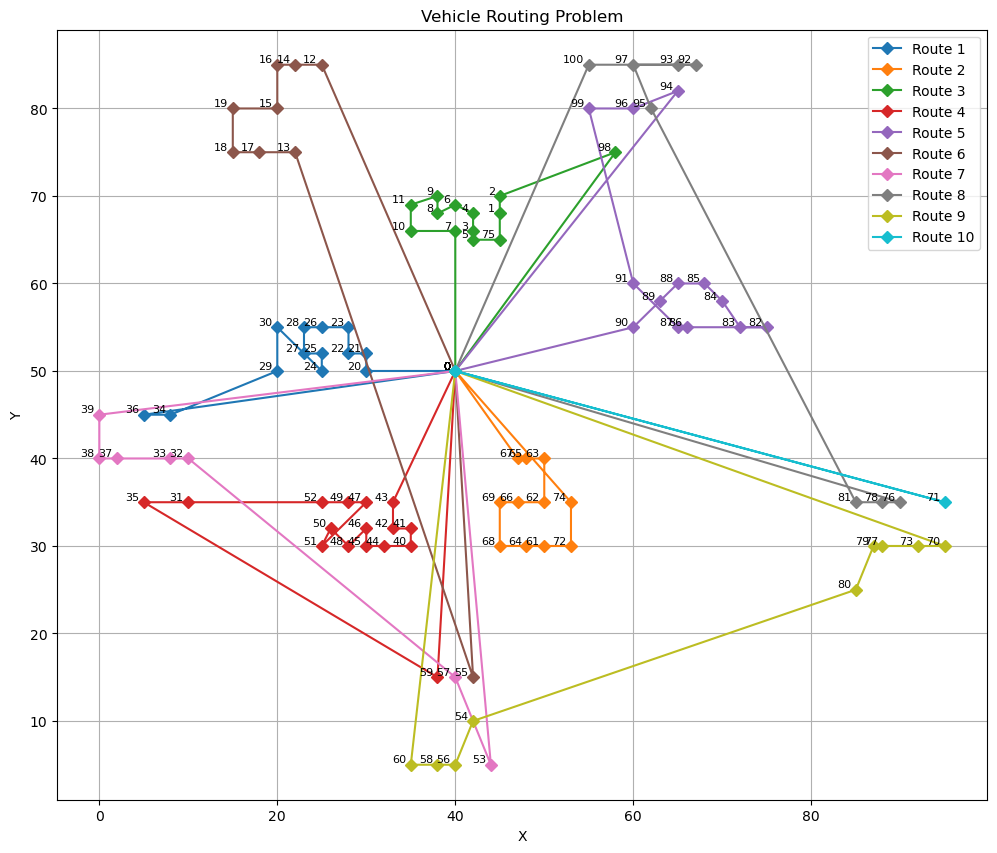

In [2]:
#Use two opt
def two_opt(routes, adj_matrix, num_iterations):
    best_routes = routes.copy()

    for _ in range(num_iterations):
        selected_route_index = np.random.randint(0, len(routes))
        selected_route = routes[selected_route_index]

        i, j = np.random.randint(1, len(selected_route) - 1, size=2)
        if j < i:
            i, j = j, i

        new_route = selected_route.copy()
        new_route[i:j] = selected_route[j - 1: i - 1: -1]  # Reverse the path between i and j

        new_routes = routes.copy()
        new_routes[selected_route_index] = new_route

        if calculate_total_distance(new_routes[selected_route_index], adj_matrix) < calculate_total_distance(
                best_routes[selected_route_index], adj_matrix
        ):
            best_routes = new_routes

    return best_routes

def vrp_solver2(filename, num_iterations):
    """
    Solve the VRP using the provided filename for coordinates, vehicle capacity,
    and number of iterations for the two-opt optimization.
    """
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time  = read_txt_file(filename)
    adj_matrix = adjacency_matrix(coordinates)
    all_routes, capacity_list = nearest_neighbor(adj_matrix, demand, int(capacity_max))
    route_distances = [calculate_total_distance(route, adj_matrix) for route in all_routes]

    for i in range(len(all_routes)):
        route = all_routes[i]
        optimized_route = two_opt([route], adj_matrix, num_iterations)[0]
        all_routes[i] = optimized_route

    formatted_routes = format_output(all_routes)
    return formatted_routes, route_distances

filename = "c101.txt"
num_iterations = 100000
solution, route_distances = vrp_solver2(filename, num_iterations)

n = 0
for route, distance in zip(solution, route_distances):  
    print("Route " + str(n+1) + ": "+ str(route) + "\nTruck capacity: " + str(capacity_list[n]) + "\nTotal distance travelled: " + str(distance) + "\n")
    n = n+1
plot_routes_with_coordinates(coordinates, solution)